In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import sys, os
sys.path.append(os.path.abspath(".."))
from src.pipelines.feature_engineering import FeatureBuilder


In [3]:
df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

y = df["Churn"].map({"Yes": 1, "No": 0})
X = df.drop(columns=["Churn"])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [4]:
xgb_pipeline = Pipeline(
    steps=[
        ("features", FeatureBuilder()),
        ("model", XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
            eval_metric="logloss",
            random_state=42
        ))
    ]
)


In [5]:
xgb_pipeline.fit(X_train, y_train)

xgb_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

print("XGBoost ROC-AUC:",
      roc_auc_score(y_test, xgb_proba))

print("XGBoost PR-AUC:",
      average_precision_score(y_test, xgb_proba))


XGBoost ROC-AUC: 0.8318840579710145
XGBoost PR-AUC: 0.6068551600275115


In [6]:
lgbm_pipeline = Pipeline(
    steps=[
        ("features", FeatureBuilder()),
        ("model", LGBMClassifier(
            n_estimators=500,
            num_leaves=31,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            class_weight="balanced",
            random_state=42
        ))
    ]
)


In [7]:
lgbm_pipeline.fit(X_train, y_train)

lgbm_proba = lgbm_pipeline.predict_proba(X_test)[:, 1]

print("LightGBM ROC-AUC:",
      roc_auc_score(y_test, lgbm_proba))

print("LightGBM PR-AUC:",
      average_precision_score(y_test, lgbm_proba))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM ROC-AUC: 0.8174649306362861
LightGBM PR-AUC: 0.5751054152313018


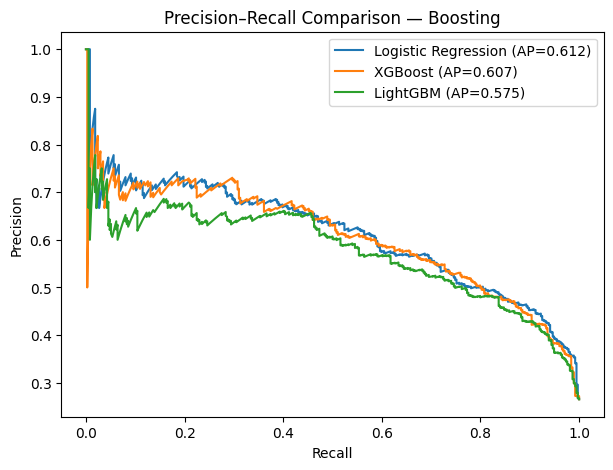

In [9]:
models = {
    "Logistic Regression": np.load("../artifacts/y_proba.npy"),     
    "XGBoost": xgb_proba,
    "LightGBM": lgbm_proba
}

plt.figure(figsize=(7, 5))

for name, proba in models.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Comparison — Boosting")
plt.legend()
plt.show()
